## Task 06.1: Understanding Basic Recurrent Neural Networks (RNNs)

ITU KSADMAL1KU - Advanced Machine Learning for Computer Science 2023

by Stefan Heinrich, with material by Kevin Murphy.

This notebook is based on Based on sec 8.5 of http://d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html with further contributions by Murphy.

All info and static material: https://learnit.itu.dk/course/view.php?id=3022225

-------------------------------------------------------------------------------


In [29]:
# @title #### Import dependencies

import numpy as np
import matplotlib.pyplot as plt
import math
from IPython import display 

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data

import collections
import re
import random
import os
import requests
import hashlib
import time

np.random.seed(seed=1)
torch.manual_seed(1)
!mkdir figures # for saving plots


mkdir: figures: File exists


#### Load the data

As data, we use the book "The Time Machine" by H G Wells,
preprocessed using the code in [this colab](https://github.com/probml/pyprobml/blob/master/notebooks/tutorials/text_preproc_torch.ipynb).
Don't spend much time on understanding the details of the preprocessing but grasp the overall concept of how the **vocabulary is built** and what the **role of "num_steps"** is.

In [30]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

def load_data_time_machine(batch_size, num_steps, use_random_iter=False,
                           max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter,
                              max_tokens)
    return data_iter, data_iter.vocab

In [31]:
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

def seq_data_iter_random(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

In [32]:
class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [33]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['time_machine'] = (DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

# load data as function (thus, will be executed later!)
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

##### Inspect some of the data

In [34]:
# Print lines 0, 8 and 11 of the original text, after it was stripped from standard non-characters:
X = read_time_machine()
print(X[0])
print(X[8])
print(X[11])
# Note: this stripping, as a pre-processing step, can already remove important cues for meaning.

the time machine by h g wells
the time traveller for so it will be convenient to speak of him
fire burned brightly and the soft radiance of the incandescent


### Build the model - Variant 1: RNN from scratch

We fit an unconditional RNN, for language modeling (ie. not vec2seq or seq2seq. Following the D2L notation, the model has the form
$$\begin{align}
H_t &= \phi(X_t W_{xh} + H_{t-1}  W_{hh} + b_h) \\
O_t &= H_t W_{hq} + b_q
\end{align}
$$
where $X_t$ is the $(n,d)$ matrix of (one-hot) inputs 
(for batch size $n$ and vocabulary size $d$),
$H_t$ is the $(n,h)$ matrix of hidden states 
(for $h$ hidden states),
and $O_t$ is the $(n,q)$ matrix of output logits
(for $q$ output labels, often $q=d$).
 


In [35]:
# Create the initial parameters

def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [42]:
# Create the initial state
# We assume this is a tuple of one element (later we will use longer tuples)
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)
    # return (nn.init.uniform_(torch.zeros((batch_size, num_hiddens), device=device)),)


In [43]:
# Forward function. 
# Input sequence is (T,B,V), where T is length of the sequence, B is batch size, V is vocab size.
# We iterate over each time step, and process the batch (for that timestep in parallel).
# Output sequence is (T*B, V), since concatante all the time steps.
# We also return the final state, so we can process the next subsequence.

def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [44]:
# Make the model class 
# Input X to call is (B,T) matrix of integers (from vocab encoding).
# We transpse this to (T,B) then one-hot encode to (T,B,V), where V is vocab.
# The result is passed to the forward function.
# (We define the forward function as an argument, so we can change it later.)

class RNNModelScratch: 
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [45]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
      return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [46]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, try_gpu(), get_params,
                      init_rnn_state, rnn)

In [47]:
X = torch.arange(10).reshape((2, 5)) # batch 2, sequence length is 5
state = net.begin_state(X.shape[0], try_gpu())
print(len(state)) # length 1
print(state[0].shape) # (2,512)

Y, new_state = net(X.to(try_gpu()), state)
print(len(vocab)) # 28
print(Y.shape) # (2x5, 28)

1
torch.Size([2, 512])
28
torch.Size([10, 28])


#### The prediction (generation) task

We pass in an initial prefix string, that is not generated. This is used to "warm-up" the hidden state. Specifically, we update the hidden state given the observed prefix, but don't generate anything. After that, for each of the T steps, we compute the (1,V) output tensor, pick the argmax index, and append it to the output. Finally, we convert the to indices to readable token sequence of size (1,T). (Note that this is a greedy, deterministic procedure.)

(D2L calls this `predict_ch8` since it occurs in their chapter 8.)

In [48]:
def predict(prefix, num_preds, net, vocab, device):  
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [49]:
# sample 50 characters after the prefix.
# since the model is untrained, the results will be garbage.
predict('time traveller ', 50, net, vocab, try_gpu())


'time traveller rpwpwpwpwpwpwpwpwpwpwpwpwpwpwpwpwpwpwpwpwpwpwpwpwp'

#### Training


To ensure the gradient doesn't blow up when doing backpropagation through many layers, we use gradient clipping, which corresponds to the update
$$
g := \min(1, \theta /||g||) g
$$
where $\theta$ is the scaling parameter, and $g$ is the gradient vector.



In [50]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

The training step is fairly standard, except for the use of gradient clipping, and the issue of the hidden state.
If the data iterator uses random ordering of the sequences, we need to initialize the hidden state for each minibatch. However, if the data iterator uses sequential ordering, we only initialize the hidden state at the very beginning of the process. In the latter case, the hidden state will depend on the value at the previous minibatch. We detach the state vector to prevent gradients flowing across minibatch boundaries. 

The state vector may be a tensor or a tuple, depending on what kind of RNN we are using. In addition, the parameter updater can be a built-in optimizer, or the simpler D2L sgd optimizer.


##### Utility functions
*Note*: Ignore the methods in this section. The code is not necessary to unterstand for the tasks. They are just used for some nicer visualisations.

In [51]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

##### Training loop (over epoch)

In [55]:
def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, Timer()
    metric = Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1) #(B,T) -> (T,B)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            # grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            # grad_clipping(net, 1)
            # batch_size=1 since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

The main training function is fairly standard.
The loss function is per-symbol cross-entropy, $-\log q(x_t)$, where $q$ is the model prediction from the RNN. Since we compute the average loss across time steps within a batch, we are computing $-\frac{1}{T} \sum_{t=1}^T \log p(x_t|x_{1:t-1})$. The exponential of this is the perplexity (ppl). We plot this metric during training, since it is independent of document length. In addition, we print the MAP sequence prediction following the suffix 'time traveller', to get a sense of what the model is doing.

In [56]:
def train(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: sgd(net.params, lr, batch_size)
    num_preds = 50
    predict_ = lambda prefix: predict(prefix, num_preds, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            # sample again after the prefix (live during training).
            # the result should be better now.           
            print(predict_('time traveller '))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')

    # sample again after the prefix (live during training).
    # the result should be better now.
    print(predict_('time traveller '))


time traveller prover ablectone sog the fime travelleriple at i g


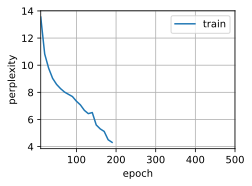

In [57]:
num_epochs, lr = 500, 1
device = try_gpu()
torch.manual_seed(42)
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                      init_rnn_state, rnn)
train(net, train_iter, vocab, lr, num_epochs, try_gpu())  

#### Analysis
Inspect some more results:

In [24]:
num_preds = 400
predict_ = lambda prefix: predict(prefix, num_preds, net, vocab, device)

print(predict_('time traveller '))
print(predict_('the '))
print(predict_('fire burnt brightly '))


time traveller with a slight accession ofcheerfulness really this is what is meant by the fourth dimensionthough some people who talk about the fourth dimension do not knowthey mean it it is only another way of looking at time there isno difference between time and any of the three dimensions of spaceexceptardimmatica ilico veni trentewind the time traveller held in his hand was a glitteringmetallic framework sc
the time machine by h g wellsithe time traveller for so it will be convenient to speak of himwas expounding a recondite matter to us his grey eyes shone andtwinkled and his usually pale face was flushed and animated thefire burned brightly and the soft radiance of the incandescentlights in the lilies of silver caug dou have been at work upon thisgeometry of four dimensions for some time some of my res
fire burnt brightly on hha kite tace bedt can andinstontave the earsh sherathe whole world has gone wrong we are always getting away from thepresent moment our mental existences w

### Build the model - Variant 2: Creating a PyTorch module

We now show how to use create an RNN as a module, which is faster than our pure Python implementation.

First we create a single hidden chain to represent the state.

In [28]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

batch_size, num_steps = 32, 35
num_layers = 1
state = torch.zeros((num_layers, batch_size, num_hiddens)) 
state.shape


torch.Size([1, 32, 256])

Now we update the state with a random one-hot tensor of inputs.

In [ ]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

Now we make an RNN module.

In [ ]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # If the RNN is bidirectional (to be introduced later),
        # `num_directions` should be 2, else it should be 1.
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device))

Test the untrained model.

In [ ]:
device = try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)

Train it. The results are similar to the 'from scratch' implementation, but much faster.

In [ ]:
num_epochs, lr = 500, 1
train(net, train_iter, vocab, lr, num_epochs, device)
predict('time traveller ', 50, net, vocab, device)

#### Analysis
Inspect some more results again.

In [ ]:
num_preds = 400
predict_ = lambda prefix: predict(prefix, num_preds, net, vocab, device)

print(predict_('time traveller '))
print(predict_('the '))
print(predict_('fire burnt brightly '))
